In [1]:
# Regression Prediction
# Build a Model to  predict the fuel efficiency of late-1970s and early 1980s automobiles. 
# This example download a dataset of many automobiles from that time period. 
# The raw dataset includes attributes like: cylinders, displacement, horsepower, and weight.
# Aim to predict the output of a continuous value, like a price or a probability

from __future__ import absolute_import, division, print_function
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

1.13.1


In [2]:
dataset_path = keras.utils.get_file("auto-mpg.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

32768/30286 [================================] - 14s 431us/step


'd:\\tensorflow\\.keras\\datasets\\auto-mpg.data'

In [3]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin'] 

In [4]:
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

In [5]:
dataset = raw_dataset.copy()

In [6]:
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [7]:
# Data Cleansing
dataset.isna().sum()
# 6 rows of horsepower with value are NA (None or NaN)

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [8]:
# Drop these NA rows
dataset = dataset.dropna()

In [9]:
# The "Origin" column is really categorical, not numeric. So convert that to a one-hot:
origin = dataset.pop('Origin')

In [10]:
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


In [34]:
# Split data into Train and Test Set
# use the test set in the final evaluation of our model.
# 80% of data to be train dataset
train_dataset = dataset.sample(frac=0.8,random_state=0)


In [35]:
test_dataset = dataset.drop(train_dataset.index)
test_dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
9,15.0,8,390.0,190.0,3850.0,8.5,70,1.0,0.0,0.0
25,10.0,8,360.0,215.0,4615.0,14.0,70,1.0,0.0,0.0
28,9.0,8,304.0,193.0,4732.0,18.5,70,1.0,0.0,0.0
31,25.0,4,113.0,95.0,2228.0,14.0,71,0.0,0.0,1.0
33,19.0,6,232.0,100.0,2634.0,13.0,71,1.0,0.0,0.0


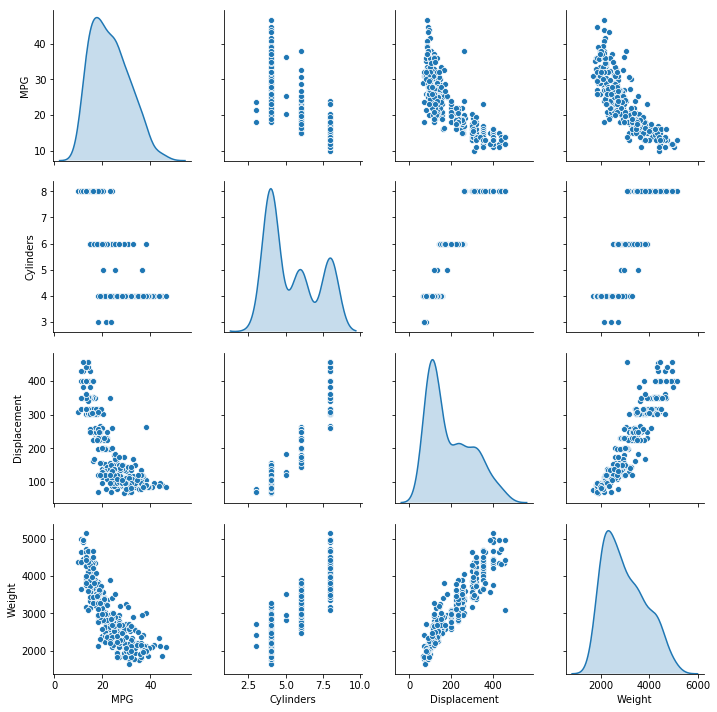

In [16]:
# joint distribution of a few pairs of columns from the training set
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [17]:
# Inspect overall statistics
train_stats = train_dataset.describe()

In [18]:
train_stats.pop("MPG")

count    314.000000
mean      23.310510
std        7.728652
min       10.000000
25%       17.000000
50%       22.000000
75%       28.950000
max       46.600000
Name: MPG, dtype: float64

In [19]:
train_stats = train_stats.transpose()

In [20]:
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [36]:
# Split features from Labels
# Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.
train_labels = train_dataset.pop('MPG')

In [37]:
test_labels = test_dataset.pop('MPG')

In [39]:
# Normalize 
# good practice to normalize features that use different scales and ranges
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [ ]:
# Build 'Sequential Model' 
# two densely connected hidden layers, and an output layer that returns a single, continuous value.

In [40]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

In [41]:
model = build_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [42]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [43]:
# Model Prediction
# ake a batch of 10 examples from the training data and call model.predict on it.
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[0.7441266 ],
       [0.42894125],
       [0.28906253],
       [0.57320124],
       [0.43522564],
       [0.22497407],
       [0.46938825],
       [0.30909386],
       [0.25530854],
       [0.18069366]], dtype=float32)

In [44]:
# Train Model
# Train the model for 1000 epochs, and record the training and validation accuracy in the history object.
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])

Instructions for updating:
Use tf.cast instead.

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................

In [45]:
# Visualize the model's training progress using the stats stored in the history object.
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,2.931153,1.114658,2.931153,10.056264,2.428872,10.056265,995
996,3.088182,1.155264,3.088182,9.256935,2.336611,9.256935,996
997,3.138823,1.141346,3.138823,10.464725,2.463185,10.464725,997
998,3.321104,1.204714,3.321104,9.431793,2.370554,9.431794,998
999,3.128652,1.155272,3.128652,9.150514,2.330912,9.150515,999


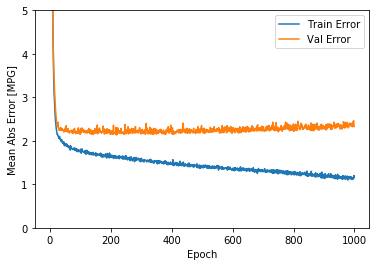

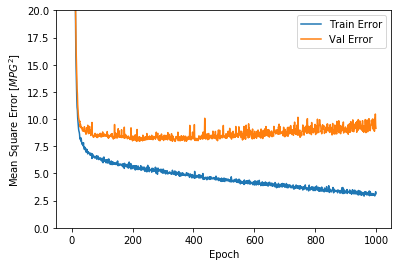

In [46]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)


.......................................................

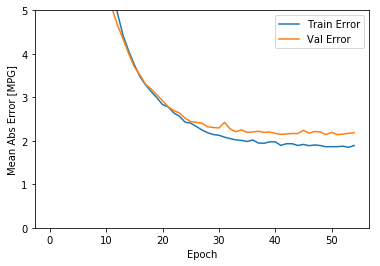

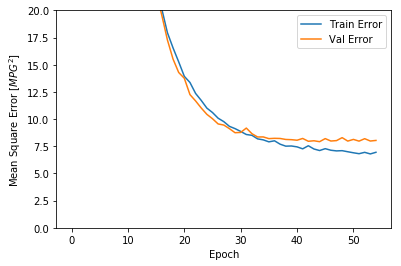

In [47]:
# model.fit call to automatically stop training when the validation score doesn't improve. 
# Use an EarlyStopping callback that tests a training condition for every epoch. 
# If a set amount of epochs elapses without showing improvement, then automatically stop the training.

model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [48]:
#  model generalizes by using the test set, which we did not use when training the model. 
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

Testing set Mean Abs Error:  1.82 MPG


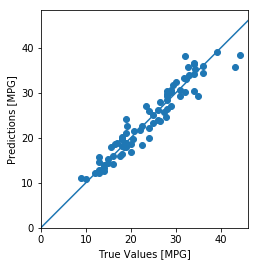

In [49]:
# Model Prediction
# predict MPG values using data in the testing set
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

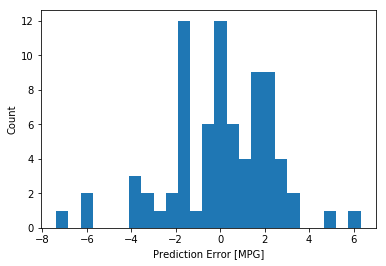

In [50]:
# CHeck Error distribution from Test Prediction
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")